# Client Churn Prediction
### CRISP-DM Cycle 4
---
The Top Bank company operates in Europe with a bank account as the main product, this product can keep client's salary and make payments. This account doesn't have any cost in the first 12 months, however, after that time trial, the client needs to rehire the bank for upcoming 12 months and redo this process every year. Recently the Analytics Team noticed that the churn rate is increasing.

As a Data Science Consultant, you need to create an action plan to decrease the number of churn customers and show the financial return on your solution.
At the end of your consultancy, you need to deliver to the TopBottom CEO a model in production, which will receive a customer base via API and return that same base with an extra column with the probability of each customer going into churn.
In addition, you will need to provide a report reporting your model's performance and the financial impact of your solution. Questions that the CEO and the Analytics team would like to see in their report:

1.  What is Top Bank's current Churn rate?
2.  How does the churn rate vary monthly?
3.  What is the performance of the model in classifying customers as churns
4.  What is the expected return, in terms of revenue, if the company uses its model to avoid churn from customers?

> Disclaimer: This is a fictional business case

## 0. Preparation

### 0.1 Imports & Settings

In [1]:
from IPython.core.display import HTML
from pathlib import Path
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from src.utils_feature_selection import multiple_histplots, apply_log_transformation, apply_one_hot_encoder, apply_standard_scaler, apply_min_max_scaler, apply_robust_scaler, plot_feature_importance, select_features_with_rfe

In [2]:
def jupyter_settings():
    """
    Plots pre settings.
    """

    %matplotlib inline
    plt.style.use("seaborn-v0_8-whitegrid")
    plt.rcParams["figure.figsize"] = [25, 12]
    plt.rcParams["font.size"] = 24
    display(HTML("<style>.container {width:100% !important;}</style>"))
    sns.set()


jupyter_settings()

seed = 42

### 0.3 Path

In [3]:
# found the main project folders
path = Path().resolve().parent
data_path = path / "data/processed"

### 0.4 Data

This dataset is available [here](https://www.kaggle.com/mervetorkan/churndataset).


**Data fields**

- **RowNumber**: the number of the columns
- **CustomerID**: unique identifier of clients
- **Surname**: client's last name
- **CreditScore**: clients credit score for the financial market
- **Geography**: the country of the client
- **Gender**: the gender of the client
- **Age**: the client's age
- **Tenure**: number of years the client is in the bank 
- **Balance**: the amount that the client has in their account 
- **NumOfProducts**: the number of products that the client bought 
- **HasCrCard**: if the client has a credit card 
- **IsActiveMember**: if the client is active (within the last 12 months) 
- **EstimateSalary**: estimate of annual salary of clients 
- **Exited**: if the client is a churn (*target variable*)

In [4]:
X_train = pd.read_parquet(data_path / "X_train.parquet")
X_test = pd.read_parquet(data_path / "X_test.parquet")
X_val = pd.read_parquet(data_path / "X_val.parquet")
y_train = pd.read_pickle(data_path / "y_train.pkl")
y_test = pd.read_pickle(data_path / "y_test.pkl")
y_val = pd.read_pickle(data_path / "y_val.pkl")

In [5]:
X_train.columns

Index(['credit_score', 'geography', 'gender', 'age', 'tenure', 'balance',
       'num_of_products', 'has_cr_card', 'is_active_member',
       'estimated_salary', 'age_squared', 'balance_sqrt',
       'credit_score_num_of_products', 'age_balance', 'engagement_score',
       'customer_value_normalized', 'product_density', 'balance_salary_ratio',
       'credit_score_age_ratio', 'tenure_age_ratio', 'credit_salary_ratio',
       'balance_indicator', 'life_stage', 'cs_category', 'tenure_group',
       'credit_score_gender', 'balance_age', 'salary_rank_geography'],
      dtype='object')

## 3. Feature Selection

### 3.1 Data Preparation

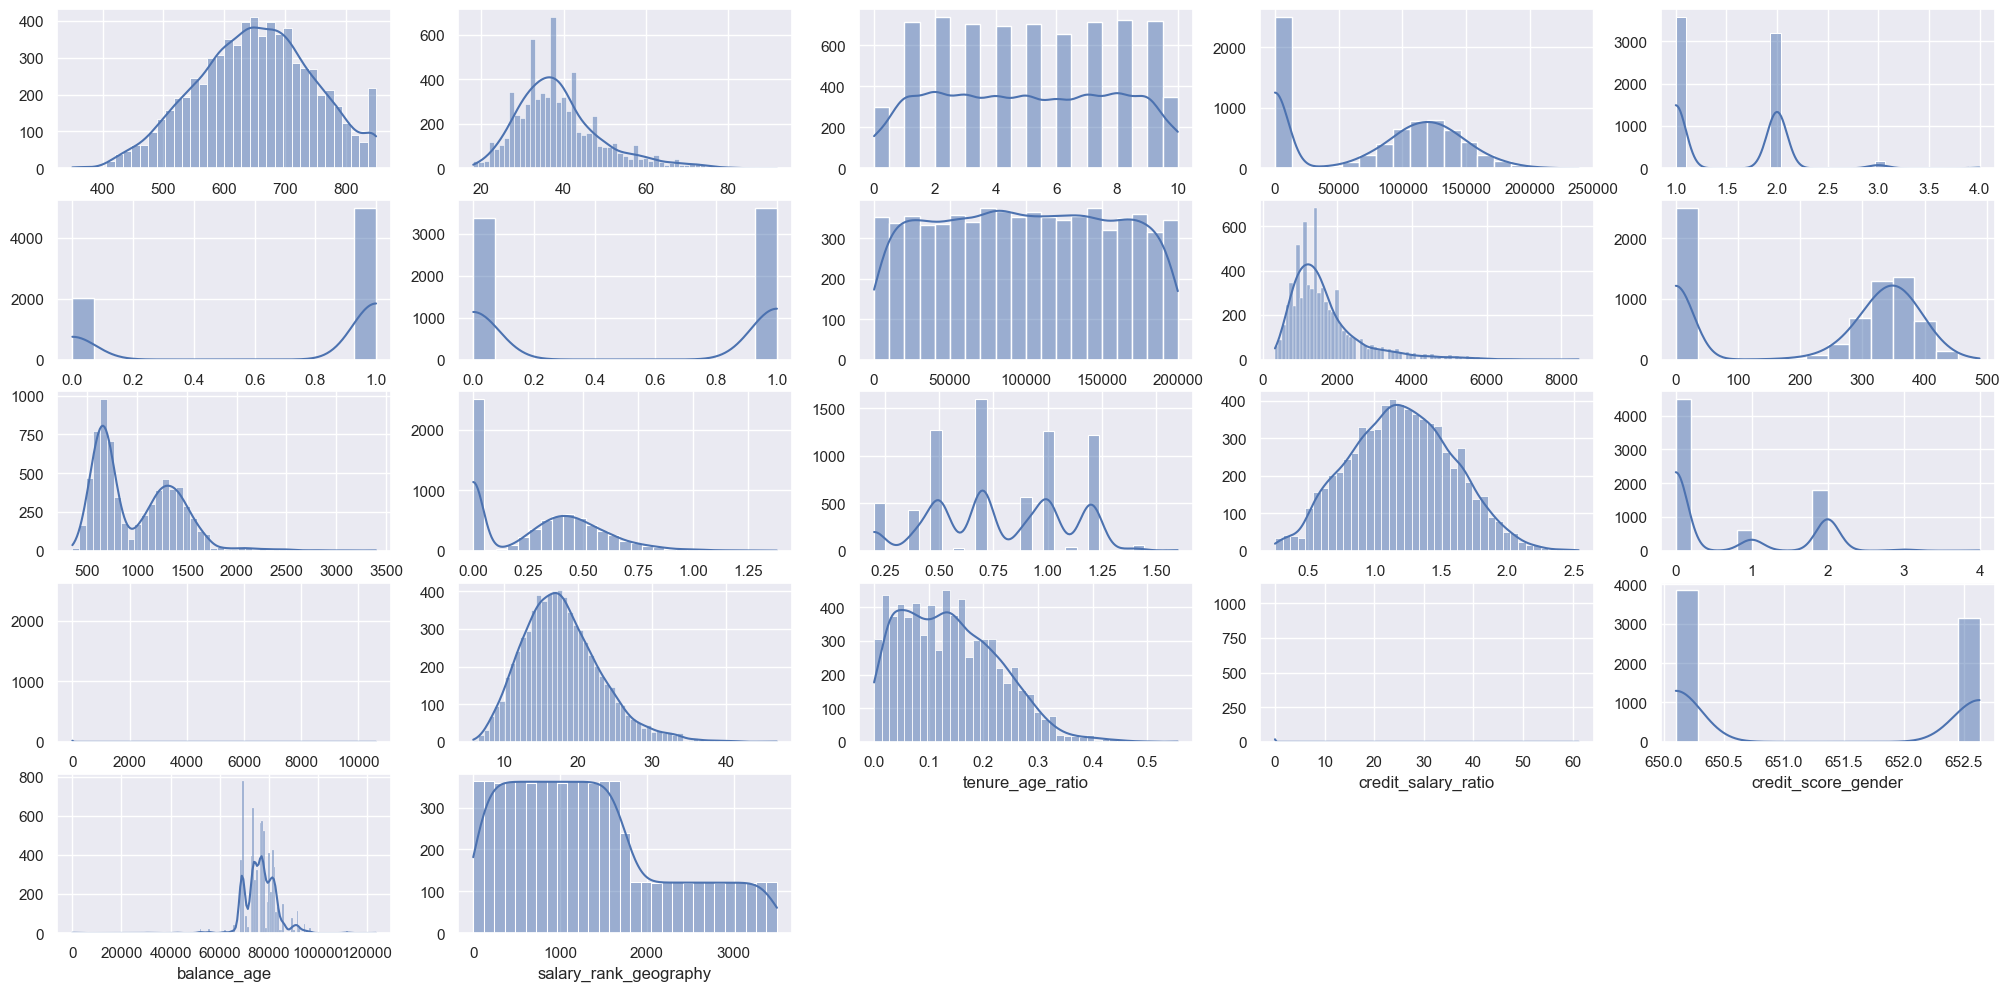

In [6]:
multiple_histplots(X_train.select_dtypes(include = ['int64', 'float64']), 5, 5);

### Scaling

##### **How it works**
-  `StandardScaler`: Standardizes features by subtracting the mean and then scaling to unit variance. This transforms the data so that it has zero mean and a standard deviation of one.
-  `MinMaxScaler`: Transforms features by scaling each feature to a given range, usually 0 to 1, or -1 to 1 if there are negative values.
-  `RobustScaler`: Scales features using statistics that are robust to outliers, by subtracting the median and dividing by the interquartile range (IQR).

##### **When to use**
- `StandardScaler`: When your data approximately follows a normal distribution. It's useful when algorithms are sensitive to the scale of the data, such as neural networks, clustering algorithms, and KNN.
- `MinMaxScaler`: When the scale of the feature is unknown or varies a lot. When you need a bounded scaling range. It's useful when your data contains outliers, and you do not want these extreme points to dominate the scaling.
- `RobustScaler`: When you have outliers, and you want to reduce their influence. It's useful when you have a small dataset or/and you want to avoid the influence of outliers.

##### Analyzing the distributions and the boxplots, we can draw some conclusions.

- `credit_score`: The distribution is close to a normal distribution, but there are some outliers. We can use `StandardScaler` if consider as a normal distribution or `MinMaxScaler` to normalize.

- `age`: Age is sensitive to outliers, so we can use `RobustScaler`.

- `tenure`: `MinMaxScaler` is the best option.

- `balance`: The distribution is not normal and has a lot of outliers. We can use `RobustScaler`.

- `estimated_salary`: The distribution is not normal and has a lot of outliers. We can use `RobustScaler`.

- `age_squared`: We can use `RobustScaler`.

- `balance_sqrt`: We can use `RobustScaler`.

- `credit_score_num_of_products`: `StandardScaler` if the distribution is normal or `MinMaxScaler` if not.

- `age_balance`: `RobustScaler` is the best option.

- `engagement_score`: `StandardScaler` is the best option.

- `customer_value_normalized`: There's not necessary to scale this feature.

- `product_density`: `RobustScaler` is the best option.

- `balance_salary_ratio`: `RobustScaler` is the best option.

- `credit_score_age_ratio`: `RobustScaler` is the best option.

- `tenure_age_ratio`: `RobustScaler` is the best option.

- `credit_salary_ratio`: `RobustScaler` is the best option.

### Encoding

##### **How it works**
- `One-Hot Encoding`: Creates a new column for each level of the categorical variable and assigns a value of 1 or 0 to each column in each row, depending on the presence of the attribute.
Use: Useful when categories do not have a natural order or hierarchy. This prevents the model from assigning an order where there isn't one, but can significantly increase the number of dimensions in the dataset.
Disadvantage: Can lead to a problem known as the "curse of dimensionality" in large datasets.

- `Label Encoding`: Converts each category value into an integer. Unique values are enumerated.
Use: Suitable for categorical variables with some natural order or hierarchy (ordinal), such as low, medium, high.
Disadvantage: Models may incorrectly interpret the data as having some form of numerical order or scale where it is not desired or true.

- `Binary Encoding`: Combines aspects of Label encoding and One-hot encoding. First, categorical values are converted into integers, and then those integers are converted into binary. Finally, the bits of the binary value are split into separate columns.
Use: When you have many categories, but One-hot encoding would add too many columns.
Frequency Encoding:
Description: Replaces categories with the frequency or percentage of observations in that category.
Use: Useful when the frequency of the categories is important for prediction and to avoid increasing dimensionality.

- `Frequency Encoding`: Replaces categories with the frequency or percentage of observations in that category.
Use: Useful when the frequency of the categories is important for prediction and to avoid increasing dimensionality.

##### Analyzing the features, we can draw some conclusions.

- `geography`: We can use `One-Hot Encoding`.
- `gender`: We can use `Label Encoding` or `One-Hot Encoding`.
- `tenure_group`: We can use `One-Hot Encoding`.
- `life_stage`: We can use `One-Hot Encoding` or `Label Encoding`.
- `balance_indicator`: We can use `One-Hot Encoding` or `Label Encoding`.
- `cs_category`: We can use `One-Hot Encoding` or `Label Encoding`.

### Log Transformation

##### We can use log transformation to reduce the skewness of the data.
- `balance`: To do this transformation, we need to add 1 to the feature to avoid log(0).
- `balance_sqrt`: To do this transformation, we need to add 1 to the feature to avoid log(0).
- `age_balance`: To do this transformation, we need to add 1 to the feature to avoid log(0).
- `age`: We can apply log transformation to this feature.
- `age_squared`: We can apply log transformation to this feature.

In [7]:
for dataframe in X_train, X_test, X_val:
    dataframe["balance"] = dataframe["balance"].apply(lambda x: 1 if x == 0 else x)
    dataframe["balance_sqrt"] = dataframe["balance_sqrt"].apply(
        lambda x: 1 if x == 0 else x
    )
    dataframe["age_balance"] = dataframe["age_balance"].apply(
        lambda x: 1 if x == 0 else x
    )

In [8]:
# datasets
data = [X_train, X_test, X_val]

# log transform
log_cols = ["balance", "balance_sqrt", "age_balance", "age", "age_squared"]

# encoding
ohe_cols = ["geography", "gender", "tenure_group", "life_stage", "balance_indicator", "cs_category"]

# re-scaling
standard_scaler = ["credit_score_num_of_products", "engagement_score"]

min_max_scaler = ["credit_score", "tenure"]

robust_scaler = ["age", "balance", "estimated_salary", "age_squared", "balance_sqrt", "age_balance", "product_density", "balance_salary_ratio", "credit_score_age_ratio", "tenure_age_ratio", "credit_salary_ratio"]

In [9]:
apply_log_transformation(data, log_cols)
apply_one_hot_encoder(data, ohe_cols)
apply_standard_scaler(data, standard_scaler)
apply_min_max_scaler(data, min_max_scaler)
apply_robust_scaler(data, robust_scaler)

### 3.2 Feature Selection

#### 3.2.1 Extra Trees Classifier

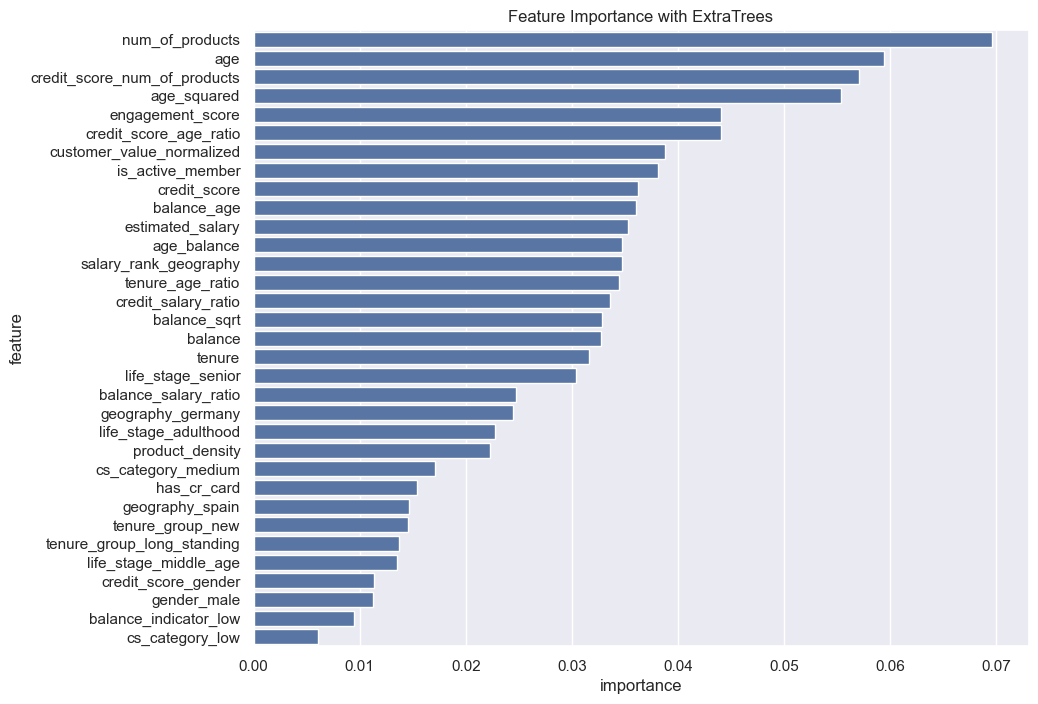

,feature,importance
0,num_of_products,0.069538
1,age,0.059360
2,credit_score_num_of_products,0.057023
3,age_squared,0.055362
4,engagement_score,0.044084
5,credit_score_age_ratio,0.044003
6,customer_value_normalized,0.038775
7,is_active_member,0.038067
8,credit_score,0.036182
9,balance_age,0.036026


In [10]:
plot_feature_importance(X_train, y_train, "ExtraTrees")

#### 3.2.2 Random Forest Classifier

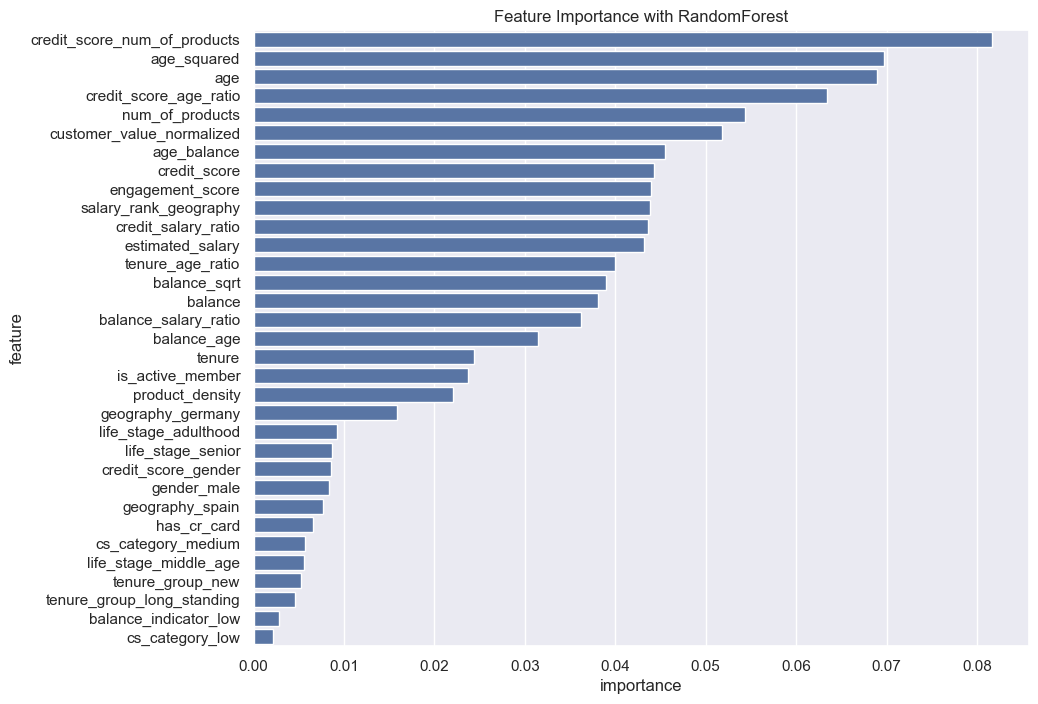

,feature,importance
0,credit_score_num_of_products,0.081610
1,age_squared,0.069678
2,age,0.068942
3,credit_score_age_ratio,0.063370
4,num_of_products,0.054346
5,customer_value_normalized,0.051764
6,age_balance,0.045511
7,credit_score,0.044259
8,engagement_score,0.043910
9,salary_rank_geography,0.043850


In [11]:
plot_feature_importance(X_train, y_train, "RandomForest")

#### 3.2.3 RFE

In [12]:
select_features_with_rfe(X_train, y_train)

Index(['credit_score', 'age', 'num_of_products', 'estimated_salary',
       'age_squared', 'credit_score_num_of_products', 'age_balance',
       'engagement_score', 'customer_value_normalized',
       'credit_score_age_ratio', 'credit_salary_ratio',
       'salary_rank_geography'],
      dtype='object')

### Conclusion

These are the most relevant features of the FI-ET, FI-RF, FI-RFE and Rank Features:

| Features                       | FI ExtraTrees | FI RF | FI-RFE |
|--------------------------------|---------------|-------|--------|
| `num_of_products`              | [x]           | [x]   | [x]    |
| `age`                          | [x]           | [x]   | [x]    |
| `credit_score_num_of_products` | [x]           | [x]   | [x]    |
| `age_squared`                  | [x]           | [x]   | [x]    |
| `engagement_score`             | [x]           | [x]   | [x]    |
| `credit_score_age_ration`      | [x]           | [x]   | [x]    |
| `customer_value_normalized`    | [x]           | [x]   | [x]    |
| `is_active_member`             | [x]           |       |        |
| `credit_score`                 | [x]           | [x]   |        |
| `balance_age`                  | [x]           |       |        |
| `estimated_salary`             | [x]           | [x]   | [x]    |
| `age_balance`                  | [x]           | [x]   | [x]    |
| `salary_rank_geography`        |               | [x]   | [x]    |
| `tenure_age_ratio`             |               |       |        |
| `credit_salary_ratio`          |               | [x]   | [x]    |
| `balance_sqrt`                 |               |       |        |
| `balance`                      |               |       | [x]    |
| `tenure`                       |               |       |        |
| `life_stage_senior`            |               |       |        |
| `balance_salary_ratio`         |               |       |        |
| `geography_germany`            |               |       |        |
| `life_stage_adulthood`         |               |       |        |
| `product_density`              |               |       |        |
| `cs_category_medium`           |               |       |        |
| `has_cr_card`                  |               |       |        |
| `geography_spain`              |               |       |        |
| `tenure_group_new`             |               |       |        |
| `tenure_group_long_standing`   |               |       |        |
| `life_stage_middle_age`        |               |       |        |
| `credit_score_gender`          |               |       |        |
| `gender_male`                  |               |       |        |
| `balance_indicator_low`        |               |       |        |
| `cs_category_low`              |               |       |        |
| `geography_france`             |               |       |        |
| `gender_female`                |               |       |        |



We can consider that if the feature appears in all models it is an important feature for the modelling step, in this scenario we have:
- `num_of_products`
- `age`
- `credit_score_num_of_products`
- `age_squared`
- `engagement_score`
- `credit_score_age_ration`
- `customer_value_normalized`
- `estimated_salary`
- `age_balance`

If the feature appears in two models, it is also important:
- `credit_score`
- `credit_salary_ratio`


According to the EDA, the churn ratio in Germany is higher than Spain and France, because of that, I consider these features relevant.
- `geography_germany`
- `geography_spain`
- `geography_france`

Studying a little about the business model, `estimated_salary`, `tenure`, `balance`, `is_active_member` and `geography` are the most relevant variables in a lot of cases. So, I will consider these features in the modelling step.
- `balance`
- `tenure`

With these three sources of information, I believe that the most relevant features for modeling models are:

- `num_of_products`
- `age`
- `credit_score_num_of_products`
- `age_squared`
- `engagement_score`
- `credit_score_age_ration`
- `customer_value_normalized`
- `estimated_salary`
- `age_balance`
- `credit_score`
- `credit_salary_ratio`
- `geography_germany`
- `geography_spain`
- `geography_france`
- `is_active_member`
- `balance`
- `tenure`

From 33 features, we will use 16 features in the modelling step.



In [14]:
for dataframe in [X_train, X_test, X_val]:
    dataframe = dataframe.loc[:, ["num_of_products",
                                    "age",
                                    "credit_score_num_of_products",
                                    "age_squared",
                                    "engagement_score",
                                    "credit_score_age_ratio",
                                    "customer_value_normalized",
                                    "estimated_salary",
                                    "age_balance",
                                    "credit_score",
                                    "credit_salary_ratio",
                                    "geography_germany",
                                    "geography_spain",
                                    "is_active_member",
                                    "balance",
                                    "tenure"]]
    
# Save data
X_train.to_parquet(data_path / "X_train_fs.parquet")
X_test.to_parquet(data_path / "X_test_fs.parquet")
X_val.to_parquet(data_path / "X_val_fs.parquet")